In [1]:
from meld_graph.dataset import GraphDataset
from meld_graph import experiment

/home/kw350/.conda/envs/meld_graph/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting MELD_DATA_PATH to /rds/user/kw350/rds-kw350-meld/meld_data/Data/
Setting BASE_PATH to /rds/user/kw350/rds-kw350-meld/meld_data/Data/
Setting EXPERIMENT_PATH to /rds/user/kw350/rds-kw350-meld/experiments/kw350/
No fs_subjects_path defined in /home/kw350/software/gdl/meld_classifier/meld_config.ini!
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350


In [2]:

def load_config(config_file):
    """load config.py file and return config object"""
    import importlib.machinery, importlib.util
    loader = importlib.machinery.SourceFileLoader("config", config_file)
    spec = importlib.util.spec_from_loader(loader.name, loader)
    config = importlib.util.module_from_spec(spec)
    loader.exec_module(config)
    return config

In [3]:
config = load_config('../scripts/config_files/experiment_config_konrad_synth.py')

cur_data_parameters = config.data_parameters
cur_network_parameters = config.network_parameters


In [4]:
exp = experiment.Experiment(cur_network_parameters, cur_data_parameters)

saving parameter files to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/22-09-30_synth_unet_gamma_2/fold_00
Initialised Experiment 22-09-30_synth_unet_gamma_2


In [5]:
import time
t1=time.time()
train_dset = GraphDataset.from_experiment(exp, mode='train')
t2=time.time()
print(t2-t1)

getting train val test split
total number of subjects: 46
total number of subjects after restricting to subjects from MELD_dataset_V6.csv: 46
total number of subjects: 950
total number of subjects after restricting to subjects from MELD_dataset_V6.csv: 942
total number after filtering by scanner ['3T', '15T'], features, lesional_only True: 911
full_feature_list: ['.combat.on_lh.curv.sm5.mgh', '.combat.on_lh.gm_FLAIR_0.25.sm10.mgh', '.combat.on_lh.gm_FLAIR_0.5.sm10.mgh', '.combat.on_lh.gm_FLAIR_0.75.sm10.mgh', '.combat.on_lh.gm_FLAIR_0.sm10.mgh', '.combat.on_lh.pial.K_filtered.sm20.mgh', '.combat.on_lh.sulc.sm5.mgh', '.combat.on_lh.thickness.sm10.mgh', '.combat.on_lh.w-g.pct.sm10.mgh', '.combat.on_lh.wm_FLAIR_0.5.sm10.mgh', '.combat.on_lh.wm_FLAIR_1.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.curv.sm5.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh

1.4212837219238281
0.4480268955230713
0.4214143753051758
0.4263911247253418
0.23658037185668945
0.2410736083984375
0.4376709461212158
0.4613070487976074
0.4452681541442871
0.415877103805542
0.40931153297424316
0.40631699562072754
0.044443368911743164
0.22591662406921387
0.4149751663208008
0.4079315662384033
0.40058040618896484
0.2231287956237793
0.411557674407959
0.4093782901763916
0.41036462783813477
0.40147924423217773
0.044092416763305664
0.4275815486907959
0.40260767936706543
0.40509557723999023
0.22223234176635742
0.22312402725219727
0.4222099781036377
0.22489166259765625
0.4107022285461426
0.4146602153778076
0.2275083065032959
0.4168109893798828
0.4111011028289795
0.411998987197876
0.41710710525512695
0.40520238876342773
0.4270286560058594
0.425933837890625
27.360939025878906


In [20]:
import time
def create_lesion_mask(self,radius,cartesian_coords,return_smoothed=True):
        """create irregular polygon lesion mask"""
        import matplotlib.path as mpltPath
        #from sklearn.metrics import pairwise_distances
        from scipy import interpolate,ndimage
        import copy
        from meld_graph.resampling_meshes import spinning_coords
        from meld_classifier import mesh_tools as mt
        t1=time.time()
        spun_coords = spinning_coords(cartesian_coords)
        spherical_coords = mt.spherical_np(spun_coords)[:,1:]
        spherical_coords[:,0] = spherical_coords[:,0]-np.pi/2
        spherical_coords = self.clip_spherical_coords(spherical_coords)

        #select a radius
        f_radius = np.clip(np.random.normal(radius,radius/2),0.05,2)
        
        t2=time.time()
        n_points = np.random.choice(6)+4
        subset = self.grid_coords[self.distances<f_radius]
        #establish mask and mask coordinates
        x_mask = np.logical_and(self.grid_coords_grid[0]>-f_radius,self.grid_coords_grid[0]<f_radius)
        y_mask = np.logical_and(self.grid_coords_grid[1]>-f_radius,self.grid_coords_grid[1]<f_radius)
        grid_mask = np.logical_and(x_mask
            ,y_mask
            )
        mask_shape=(x_mask.any(axis=1).sum(),y_mask.any(axis=0).sum())
        masked_grid_coords = np.vstack([self.grid_coords_grid[0][grid_mask],
                      self.grid_coords_grid[1][grid_mask]]).T
        t3=time.time()
        poly_i = np.random.choice(len(subset),n_points)
        polygon = subset[poly_i]
        polygon = np.array(sorted(polygon, key=lambda point: self.clockwiseangle_and_distance(point,self.origin)))
        path = mpltPath.Path(polygon)
        lesion = path.contains_points(masked_grid_coords)
        #lesion = path.contains_points(self.grid_coords)
        arr_lesion = lesion.reshape(mask_shape,order='f').astype(float)
        #arr_lesion = lesion.reshape(self.gridshape,order='f').astype(float)
        #interpolate to coordinates
        t4=time.time()
        full_lesion = np.zeros(self.gridshape,dtype=float)
        full_lesion[grid_mask.T] = arr_lesion.ravel()
        f_near=interpolate.RegularGridInterpolator((self.xnew,self.ynew),
                                                   full_lesion.T,
                                                  method='nearest')
        interpolated_lesion=f_near(spherical_coords)
        t5=time.time()
        #smoothed mask
        if return_smoothed:
            smoothed = ndimage.gaussian_filter(arr_lesion,10)
            full_lesion[grid_mask.T] = smoothed.ravel()
            f_lin=interpolate.RegularGridInterpolator((self.xnew,self.ynew),
                                                   full_lesion.T,
                                                  method='linear')
            #return grid_coords,smoothed
            interpolated_smoothed = f_lin(spherical_coords)
            t6=time.time()
            print(t6-t1,t2-t1,t3-t2,t4-t3,t5-t4,t6-t5)
            return interpolated_lesion, interpolated_smoothed 
        else:
            return interpolated_lesion
    

In [7]:
self = train_dset.prep
from meld_graph.icospheres import IcoSpheres
import numpy as np
icos= IcoSpheres(conv_type='SpiralConv')

i,i2=create_lesion_mask(self,0.5,icos.icospheres[7]['coords'] )

Using coord type pseudo


0.0723874568939209 0.015595436096191406 0.003774404525756836 0.0004115104675292969 0.022048473358154297 0.030557632446289062


In [8]:
self.grid_coords_grid[0].shape
self.grid_coords_grid[1].shape


(500, 1000)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
radius = 0.5
f_radius = np.clip(np.random.normal(radius,radius/2),0.05,2)
n_points = np.random.choice(6)+4
mask = (self.distances<f_radius).reshape(self.gridshape,order='f').T

In [10]:
#establish mask and parameters
x_mask = np.logical_and(self.grid_coords_grid[0]>-f_radius,self.grid_coords_grid[0]<f_radius)
y_mask = np.logical_and(self.grid_coords_grid[1]>-f_radius,self.grid_coords_grid[1]<f_radius)
grid_mask = np.logical_and(x_mask
    ,y_mask
    )
mask_shape=(x_mask.any(axis=1).sum(),y_mask.any(axis=0).sum())
masked_grid_coords = np.vstack([self.grid_coords_grid[0][grid_mask],
                      self.grid_coords_grid[1][grid_mask]]).T

In [11]:
import matplotlib.path as mpltPath
subset = self.grid_coords[self.distances<f_radius]
poly_i = np.random.choice(len(subset),n_points)
polygon = subset[poly_i]
polygon = np.array(sorted(polygon, key=lambda point: self.clockwiseangle_and_distance(point,self.origin)))
path = mpltPath.Path(polygon)
lesion = path.contains_points(masked_grid_coords)

In [12]:
mask_shape

(94, 94)

In [13]:

arr_lesion = lesion.reshape(mask_shape,order='f').astype(float)

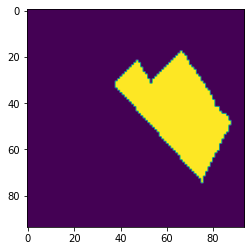

In [14]:
plt.imshow(arr_lesion)

In [15]:
from scipy import interpolate,ndimage
import copy
from meld_graph.resampling_meshes import spinning_coords
from meld_classifier import mesh_tools as mt
spun_coords = spinning_coords(icos.icospheres[7]['coords'])
spherical_coords = mt.spherical_np(spun_coords)[:,1:]
spherical_coords[:,0] = spherical_coords[:,0]-np.pi/2
spherical_coords = self.clip_spherical_coords(spherical_coords)
full_lesion = np.zeros(self.gridshape,dtype=float)
full_lesion[grid_mask.T] = arr_lesion.ravel()
f_near=interpolate.RegularGridInterpolator((self.xnew,self.ynew),
                                                   full_lesion.T,
                                                  method='nearest')
interpolated_lesion=f_near(spherical_coords)
smoothed = ndimage.gaussian_filter(arr_lesion,10)
full_lesion[grid_mask.T] = smoothed.ravel()
f_lin=interpolate.RegularGridInterpolator((self.xnew,self.ynew),
                                       full_lesion.T,
                                      method='linear')
#return grid_coords,smoothed
interpolated_smoothed = f_lin(spherical_coords)

0.05344676971435547 0.0164642333984375 0.0005757808685302734 0.00015211105346679688 0.01540374755859375 0.02085089683532715


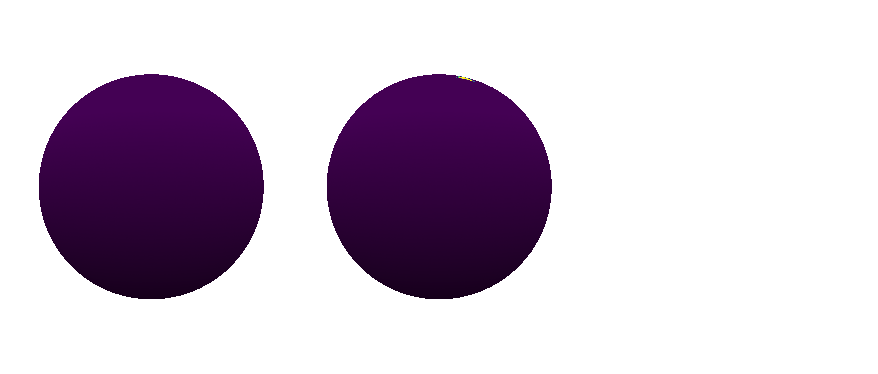

In [32]:
import matplotlib_surface_plotting as msp
self = train_dset.prep
self.initialise_distances(res=200)
i,i2=create_lesion_mask(self,0.5,icos.icospheres[7]['coords'] )
msp.plot_surf(icos.icospheres[7]['coords'],
                 icos.icospheres[7]['faces'],
                  i,
                  colorbar=False
                 )

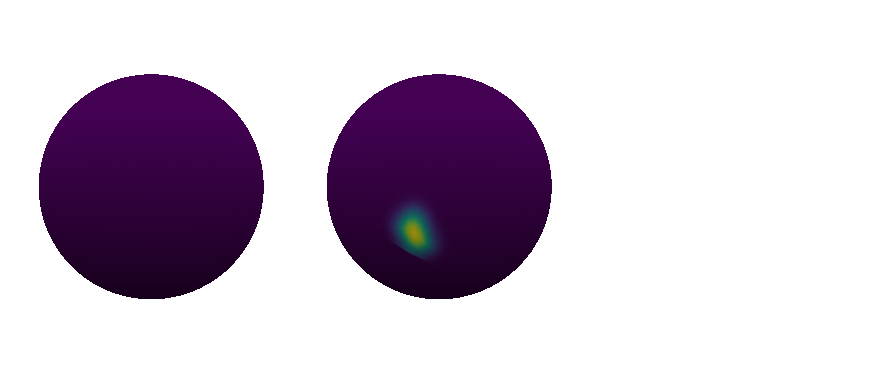

In [17]:
msp.plot_surf(icos.icospheres[7]['coords'],
                 icos.icospheres[7]['faces'],
                  interpolated_smoothed,
                  colorbar=False
                 )

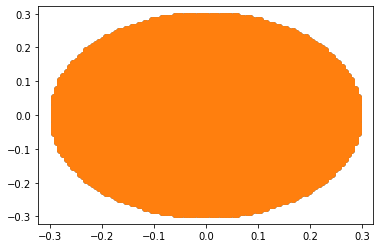

In [18]:
masked_subset = np.vstack([self.grid_coords_grid[0][mask],
self.grid_coords_grid[1][mask]]).T
plt.scatter(subset[:,0],subset[:,1])
plt.scatter(masked_subset[:,0],masked_subset[:,1])


In [19]:
self.grid_coords.

SyntaxError: invalid syntax (1534622066.py, line 1)

In [ ]:
plt.scatter(subset[:,0],subset[:,1])


In [ ]:
## 40 synthetic subjects - initialisasion ~ 8 seconds then synthesis
## original = 56.9 seconds
## precalculating distances = 35.7 s
## after masking for smoothing = 28 seconds


In [ ]:
len(train_dset)

In [ ]:
lesions=[]
for d in train_dset:
    lesions.append(int(d['y'].sum()))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(lesions,100)

In [ ]:
import numpy as np
l_f_means=np.zeros((len(lesions),33))
p_f_means=np.zeros((len(lesions),33))
for si,s in enumerate(train_dset):
    if s['y'].sum()>0:
        l_f_means[si] = s['x'][s['y']==1].mean(axis=0)
    rand_i = np.random.choice(len(lesions))
    p_f_means[si] = train_dset[rand_i]['x'][s['y']==1].mean(axis=0)

In [ ]:
import seaborn as sns

In [ ]:
fig,axes = plt.subplots(3,3,figsize=(8,8))
axes=axes.ravel()
for r in np.arange(9):
    sns.kdeplot(l_f_means[:,r],ax=axes[r])
    sns.kdeplot(p_f_means[:,r],ax=axes[r])
    axes[r].set_xlim([-3,3])
fig.text(0.5, 0.89,'Synthetic')

In [ ]:
import matplotlib_surface_plotting as msp
from meld_graph.icospheres import IcoSpheres


In [ ]:
s=train_dset[10]
c=np.array(s['x'][:,0])
msp.plot_surf(icos.icospheres[7]['coords'],
                 icos.icospheres[7]['faces'],
                  c,
                  colorbar=False
                 )
lesion=np.array(s['y']).astype(bool)
msp.plot_surf(icos.icospheres[7]['coords'],
                 icos.icospheres[7]['faces'],
                  lesion,
                  colorbar=False
                 )

In [ ]:
coords = icos.icospheres[7]['spherical_coords']
from sklearn.metrics import pairwise_distances
pairwise_distances(coords[~lesion],coords[lesion], metric='haversine')[0]

In [ ]:
def clockwiseangle_and_distance(point,origin):
        import math

        refvec = [0, 1]
        # Vector between point and the origin: v = p - o
        vector = [point[0]-origin[0], point[1]-origin[1]]
        # Length of vector: ||v||
        lenvector = math.hypot(vector[0], vector[1])
        # If length is zero there is no angle
        if lenvector == 0:
            return -math.pi, 0
        # Normalize vector: v/||v||
        normalized = [vector[0]/lenvector, vector[1]/lenvector]
        dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
        diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
        angle = math.atan2(diffprod, dotprod)
        # Negative angles represent counter-clockwise angles so we need to subtract them 
        # from 2*pi (360 degrees)
        if angle < 0:
            return 2*math.pi+angle, lenvector
        # I return first the angle because that's the primary sorting criterium
        # but if two vectors have the same angle then the shorter distance should come first.
        return angle, lenvector

In [ ]:
import matplotlib.path as mpltPath

radius=0.2
f_radius = np.clip(np.random.normal(radius,radius/2),0.05,2)

com_i = np.random.choice(len(coords))
origin = coords[com_i]
distances = pairwise_distances(origin.reshape(-1,1).T,coords, metric='haversine')[0]
n_points = np.random.choice(6)+4
subset = coords[distances<f_radius]
poly_i = np.random.choice(len(subset),n_points)
polygon = subset[poly_i]
polygon = np.array(sorted(polygon, key=lambda point: clockwiseangle_and_distance(point,origin)))
path = mpltPath.Path(polygon)
lesion = path.contains_points(coords)

In [ ]:
np.logical_and(distances<f_radius,~lesion).shape

In [ ]:
ds=pairwise_distances(coords[np.logical_and(distances<f_radius,~lesion)],coords[lesion], metric='haversine')


In [ ]:
in_dists = np.min(ds,axis=0)
in_dists = in_dists/np.max(in_dists)
#in_dists=np.clip(in_dists,0,0.02)
out_dists = np.min(ds,axis=1)
out_dists = out_dists/np.max(out_dists)
#out_dists = np.clip(out_dists,0,0.02)

In [ ]:
dist_m = np.zeros(len(lesion))
dist_m[lesion]=in_dists
dist_m[np.logical_and(distances<f_radius,~lesion)] = -out_dists


In [ ]:
msp.plot_surf(icos.icospheres[7]['coords'],
                 icos.icospheres[7]['faces'],
                  dist_m,
                  colorbar=False,
              rotate=180
                 )

In [ ]:
from scipy import interpolate
subset = np.arange(10242)
f = interpolate.interp2d(coords[subset,0],coords[subset,1],
                         lesion[subset].astype(int), kind='quintic')

xnew = np.linspace(-np.pi/2,np.pi/2,100)
ynew = np.linspace(-np.pi,np.pi,200)
znew = f(xnew, ynew)

In [ ]:
lesion

In [ ]:
plt.imshow(znew)

In [ ]:
z = 1/(1 + np.exp(-dist_m[m]*10))

In [ ]:
def sigmoid_dists(dists):
    m = dists==0
    z = 1/(1 + np.exp(-dists*10))
    z[m]=0
    return z

In [ ]:
plt.scatter(dist_m[m],z)

In [ ]:
smoothed_mask = sigmoid_dists(dist_m)

In [ ]:
msp.plot_surf(icos.icospheres[7]['coords'],
                 icos.icospheres[7]['faces'],
                  smoothed_mask,
                  colorbar=False,
              rotate=180
                 )

In [ ]:
plt.hist(smoothed_mask,100)